### Fist, authenticate to google and import librabies

In [ ]:
# # first let's install miniconda, so we can install other libraries
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [52]:
# ! pip install geemap
# import geemap
import ee
import numpy as np
import pandas as pd
from pprint import pprint
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import json
import sys
import glob
import pickle
import math
import gc

from sklearn import metrics

import cudf
import cupy as cp
from numba import cuda,jit
from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC

cudf.set_allocator("managed")

In [3]:
from google.colab import drive
drive.mount('/content/G_drive')

# cp tokens
!mkdir /root/.config/earthengine/
!cp '/content/G_drive/MyDrive/Colab Notebooks/Google_Earth_Engine_tokes/credentials' /root/.config/earthengine/credentials 

# authenticate earthengine api
ee.Initialize()

# create the tmp folder
! mkdir /content/tf_tmp

Mounted at /content/G_drive


In [77]:
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()

In [4]:
# Tensorflow setup.
import tensorflow as tf
print(tf.__version__)

2.4.1


In [5]:
# print the GPI-info
! nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-97b898d8-58bc-aa59-6445-2888e06d5085)


### Then, difine the basic parameter/path-to-data

In [6]:
# import urban-img and terrain data
mask = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classification_img/Control_1990_1992/Control_1990_1992_0").gt(-1)
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward").updateMask(mask)
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [7]:
# define the year-range
year = [f'{i}_{i+2}' for i in range(1990,2020,3)]
year_img_val_dict = {yr:i for yr,i in zip(year,range(10,0,-1))}

In [8]:
# define the limit_list that controls the periods included
limit_list = 2

In [9]:
# get all possible years for traning the projection
proj_yr = []
for k,v in year_img_val_dict.items():
  # get the t0 val/img
  t0 = k
      
  # get the t1;t2
  if v == 2:
      pass
  else:
    for val in range(v-1,1,-1):
      prj_val = val - (v - val)
      
      if  prj_val>0:
          
        prj_yr  = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
        
        t1 = [k for k,v in year_img_val_dict.items() if v==val][0]
        t2 = [k for k,v in year_img_val_dict.items() if v==prj_val][0]
                        
        proj_yr.append((t0,t1,t2))

In [10]:
# Specify the export folder 
EXPORT_FOLDER = 'Data_Bank'

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = [i for i in range(3,36,4)] + [i for i in range(45,96,10)] + [i for i in range(115,360,30)] 
KERNEL_SHAPE = [(size,size) for size in KERNEL_SIZE]

# create feature_dict for parsing the tf data
FEATURES   = ['built_up_t0', 'elevation', 'slope', 'distance', 'built_up_t1']
FEATURES_pred = ['built_up_t1', 'elevation', 'slope', 'distance', 'built_up_t2']

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 10000
EVAL_SIZE = 5000

In [11]:
# create the training patch

train_data = []

for t in proj_yr:
    
    # get the time
    t0 = t[0]
    t1 = t[1]
    t2 = t[2]
    
    # get the built-up layer
    t0_img,t1_img,t2_img = [urban.gte(year_img_val_dict[yr]).rename(f'built_up_t{i}') for i,yr in enumerate(t)]
    
    # get the expansion mask
    expansion_mask = t1_img.subtract(t0_img).rename('expansion')
    expansion_prj  = t2_img.subtract(t1_img).rename('expansion')    
    
    # import the Distance_to_built-up imgs
    Distance_t0 = ee.Image(f'users/wangjinzhulala/GEE_TF/Distance_to_urban/Distance_{t0}').rename('distance')
    Distance_t1 = ee.Image(f'users/wangjinzhulala/GEE_TF/Distance_to_urban/Distance_{t1}').rename('distance')

    # import DEM and SLOPE
    DEM = ee.Image("USGS/SRTMGL1_003")
    SLOPE = ee.Terrain.slope(DEM)

    # create a distance mask, which is to avoid the samples to be collected at pure non-urban regions
    dist_mask = Distance_t0.lt(30)
    
    # stack all bands for later tranin/eval
    train_eval_bands = t0_img.addBands(DEM).addBands(SLOPE).addBands(Distance_t0).addBands(t1_img).select(FEATURES).updateMask(dist_mask).toFloat()
    pred_bands    = t1_img.addBands(DEM).addBands(SLOPE).addBands(Distance_t1).addBands(t2_img).select(FEATURES_pred).toFloat()

    
    # convert img to neighboorhood-array
    for k_size in KERNEL_SIZE:
      list_1d = ee.List.repeat(1, k_size)
      list_2d = ee.List.repeat(list_1d, k_size)
      kernel  = ee.Kernel.fixed(k_size, k_size, list_2d)

      arrays_train_eval = train_eval_bands.neighborhoodToArray(kernel)
      arrays_pred = pred_bands.neighborhoodToArray(kernel)
      
      # add patch to a dict
      train_data.append([t0,t1,t2,k_size,arrays_train_eval,arrays_pred,pred_bands])

In [12]:
train_data = pd.DataFrame(train_data,columns = ['t0','t1','t2','k_size','arrays_train_eval','arrays_pred','img_to_proj'])
train_data

,t0,t1,t2,k_size,arrays_train_eval,arrays_pred,img_to_proj
0,1990_1992,1993_1995,1996_1998,3,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,1990_1992,1993_1995,1996_1998,7,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,1990_1992,1993_1995,1996_1998,11,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,1990_1992,1993_1995,1996_1998,15,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,1990_1992,1993_1995,1996_1998,19,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
...,...,...,...,...,...,...,...
475,2011_2013,2014_2016,2017_2019,235,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
476,2011_2013,2014_2016,2017_2019,265,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
477,2011_2013,2014_2016,2017_2019,295,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
478,2011_2013,2014_2016,2017_2019,325,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


### Step_1: Extract img patches to GCP bucket

#### Export the traning sampel to G-Drive

In [13]:
# import the research area, simplify the gemegery to reduce calculation cost
Region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")
Simplified_geo = Region.geometry().simplify(50000)
Simplified_buffer = Simplified_geo.buffer(-15000)

# split the export into patch and shards to avoide "capacity exceed"
patch_n = 10
shards = 100

In [14]:
# # export traning sample
# for idx,row in train_data.iterrows():

#   t0,t1,t2 = row['t0'],row['t1'],row['t2']
#   k_size = row['k_size']

#   # define the condition to avoide export all samples
#   if (t0,t1) == proj_yr[limit_list][0:2]:

#     # get the training sample
#     for p in range(patch_n):

#       # an empty fe_col to hold
#       geomSample = ee.FeatureCollection([])

#       for i in range(shards):
#         sample = row['arrays_train_eval'].sample(
#           region = Simplified_buffer, 
#           scale = 30,
#           numPixels = int(TRAIN_SIZE/shards/patch_n), # Size of the shard.
#           seed = i + p*shards,
#           tileScale = 8
#         )
#         geomSample = geomSample.merge(sample)

#       # export the sample
#       desc = f"training_patches_{row['t0']}_and_{row['t1']}_prj_{row['t2']}_{k_size:02}_{p:03}"
#       task = ee.batch.Export.table.toDrive(
#           collection = geomSample,
#           description = desc,
#           folder = 'Data_Bank',
#           fileNamePrefix = desc,
#           fileFormat = 'TFRecord',
#           selectors = FEATURES
#       )
#       task.start()

#       print(desc)

In [15]:
# # export eval sample
# for idx,row in train_data.iterrows():

#   t0,t1,t2 = row['t0'],row['t1'],row['t2']
#   k_size = row['k_size']

#   # define the condition to avoide export all samples
#   if (t0,t1) == proj_yr[limit_list][0:2]:

#     # get the eval sample
#     for p in range(patch_n):
#       geomSample = ee.FeatureCollection([])

#       for i in range(shards):
#         sample = row['arrays_train_eval'].sample(
#           region = Simplified_buffer, 
#           scale = 30,
#           numPixels = int(EVAL_SIZE/shards/patch_n), # Size of the shard.
#           seed = i + p*shards*10*2,         # Different seed to train 
#           tileScale = 8
#         )
#         geomSample = geomSample.merge(sample)

#       # export the sample
#       desc = f"eval_patches_{row['t0']}_and_{row['t1']}_prj_{row['t2']}_{k_size:02}_{p:03}"
#       task = ee.batch.Export.table.toDrive(
#           collection = geomSample,
#           description = desc,
#           folder = 'Data_Bank',
#           fileNamePrefix = desc,
#           fileFormat = 'TFRecord',
#           selectors = FEATURES
#       )
 
#       task.start()

#       print(desc)

#### Load the data exported from Earth Engine into a tf.data.Dataset. The following are helper functions for that.

In [16]:
def parse_tfrecord(example_proto,kernel_size,fe_names):
  """The parsing function.
  Read a serialized example 
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  fe_dict = {k:tf.io.FixedLenFeature(shape=(kernel_size,kernel_size), dtype=tf.float32) for k in  fe_names}
  return tf.io.parse_single_example(example_proto, fe_dict)


def to_tuple(inputs,kernel_size,skip,take_num):
  """Read a parsed tf-format data and return cudf-X(df) and cudf-y(Series) 

  Args:
    inputs:
      example_proto: a serialized tf-format data.
    kernel_size:
      the kernel size of the tf-data (i.e. dimisions)
    skip:
      how many samples should be skiped. Given the memory limits, 
      sometime we need to skip some samples.
    take_num:
      how many samples will be used. Given the memory limits, 
      sometime we can only include limited samples.
  Returns:
    two cudf objects: cudf-X(df) and cudf-y(Series)
  """


  # convert the tf-data to inters so to extract the numpy values
  dataset = iter(inputs.skip(skip).take(take_num))

  out_X = []
  out_y = []
  for i in dataset:
    inputsList = [i.get(key) for key in FEATURES]
    stacked = tf.stack(inputsList, axis=0)
    
    # Convert from CHW to a long vector
    mid_idx = int((kernel_size - 1)/2)
    X = tf.reshape(stacked[:-1,:,:],-1).numpy()  
    y = stacked[-1,mid_idx,mid_idx].numpy()

    out_X.append(X)
    out_y.append(y)

  # conver pd-df to cudf
  cu_x_df   = cudf.DataFrame(out_X,dtype='float32')
  cu_y_series = cudf.Series(out_y,dtype='int8')
  
    
  return cu_x_df,cu_y_series


def get_dataset(pattern,kernel_size,fe_names,skip,take_num):
  """Function to read, parse and format tf-format data to X and y for later training.

  Args:
    pattern: 
      A file pattern to match files in disk.
    kernel_size:
      the kernel size of the tf-data (i.e. dimisions)
    fe_names:
      the feature names to parse the tf-format data.
    skip:
      how many samples should be skiped. Given the memory limits, 
      sometime we need to skip some samples.
    take_num:
      how many samples will be used. Given the memory limits, 
      sometime we can only include limited samples.
  Returns:
    two cudf objects: cudf-X(df) and cudf-y(Series)
  """
  globs = glob.glob(pattern)
  dataset = tf.data.TFRecordDataset(globs, compression_type='GZIP')
  dataset = dataset.map(lambda x: parse_tfrecord(x,kernel_size,fe_names), num_parallel_calls=5)
  X,y = to_tuple(dataset,kernel_size,skip,take_num)
  return X,y

#### Sanity check of the model and GPU-variables

In [ ]:
# # Get data
# k_size = 3

# train_pattern = f"/content/G_drive/MyDrive/Data_Bank/training_patches_1990_1992_*_{k_size:02}_*.gz"
# X_train,y_train = get_dataset(train_pattern,k_size,FEATURES,0,10000) 

# # train the model
# RF_model = cuRFC(max_features=1.0,n_bins=8,n_estimators=30,max_depth=10)
# RF_model.fit(X_train,y_train)

# # empty memory
# X_train = y_train = None

# # read eval data
# eval_pattern = f"/content/G_drive/MyDrive/Data_Bank/eval_patches_1990_1992_*_{k_size:02}_*.gz"
# X_eval,y_eval = get_dataset(eval_pattern,k_size,FEATURES,5000)

# RF_pred = RF_model.predict_proba(X_eval)
# RF_model = None

### Step_2: Traning the models

In [ ]:
eval_metrics = {}

# loop through each possible year
for idx,row in train_data.iterrows():

  # get the year and kernel_size information
  t0,t1,t2 = row['t0'],row['t1'],row['t2']
  k_size = row['k_size']
  
  # define the condition to avoide export all samples
  if (t0,t1) == proj_yr[limit_list][0:2]: 


    # get the actual sample size of train/eval,
    # because GEE will drop samples with null value,
    # here we use the kernel_size of 3 to get the true size
    kernel_3_pattern = f"/content/G_drive/MyDrive/Data_Bank/training_patches_{t0}_and_{t1}_prj_{t2}_03_*.gz"
    _,kernel_3_y = get_dataset(kernel_3_pattern,3,FEATURES,0,TRAIN_SIZE)
    sample_num_x = len(kernel_3_y)

    kernel_3_pattern = f"/content/G_drive/MyDrive/Data_Bank/eval_patches_{t0}_and_{t1}_prj_{t2}_03_*.gz"
    _,kernel_3_y = get_dataset(kernel_3_pattern,3,FEATURES,0,EVAL_SIZE)
    sample_num_y = len(kernel_3_y)

    # predetermine some parameters to avoid memory exceeding
    # for 700 & size==355 sample, it takes ~20g memory, so we 
    # set this as mark to calculate other sample sizes of diff kernel size
    sample_size_x = min(sample_x,int(700/((k_size/355)**2)))
    sample_size_y = int(sample_size_x/sample_num_x*sample_num_y) 



    #___________________split the samples into chunks, so we avoid "memory_exceed" problem_______________________

    # 1) get the path for train/eval
    train_pattern = f"/content/G_drive/MyDrive/Data_Bank/training_patches_{t0}_and_{t1}_prj_{t2}_{k_size:02}_*.gz"
    eval_pattern = f"/content/G_drive/MyDrive/Data_Bank/eval_patches_{t0}_and_{t1}_prj_{t2}_{k_size:02}_*.gz"
  
    # 2) split the sample into chunks
    chunks = math.ceil(sample_num_x/sample_size_x)

    # 3) loop through each chunk
    for c in range(chunks):
      
      # how many sample to skip in this loop
      skip_x = c * sample_size_x
      skip_y = c * sample_size_y

      X_train,y_train = get_dataset(train_pattern,k_size,FEATURES,skip_x,sample_size_x)

      # instantiate the models
      LR_model = LogisticRegression()
      RF_model = cuRFC(max_features=1.0,n_bins=8,n_estimators=30,max_depth=6)
      SVM_model = SVC(probability=True)

      # fit the models
      LR_model.fit(X_train,y_train)
      RF_model.fit(X_train,y_train)
      SVM_model.fit(X_train,y_train)

      # pred the training sample itself, so we have training metrics
      LR_train_pred = LR_model.predict_proba(X_train)    
      RF_train_pred = RF_model.predict_proba(X_train)
      SVM_train_pred = SVM_model.predict_proba(X_train)

      X_train = None

      # use the model for prediction    
      X_eval,y_eval = get_dataset(eval_pattern,k_size,FEATURES,skip_y,sample_size_y)

      LR_pred = LR_model.predict_proba(X_eval)    
      RF_pred = RF_model.predict_proba(X_eval)
      SVM_pred = SVM_model.predict_proba(X_eval)    

      # add y_true, model and kernel_size to metrics
      eval_metrics['LR',k_size,c+1] = [LR_pred[1].to_array(),y_eval.to_array(),LR_train_pred[1].to_array(),y_train.to_array()]
      eval_metrics['RF',k_size,c+1] = [RF_pred[1].to_array(),y_eval.to_array(),RF_train_pred[1].to_array(),y_train.to_array()]
      eval_metrics['SVM',k_size,c+1] = [SVM_pred[1].to_array(),y_eval.to_array(),SVM_train_pred[1].to_array(),y_train.to_array()]   

      # empty memory
      X_eval = y_eval = y_train = None
      RF_model = LR_model = SVM_model = None
      
      # print out the process
      print(f"___________Kernel {k_size:03} is using {sample_size_x*c}-{min(sample_num_x,sample_size_x*(c+1))}/{sample_num_x} train and {sample_size_y*c}-{min(sample_num_y,sample_size_y*(c+1))}/{sample_num_y} eval samples; current chunk is {c+1}/{chunks}_________________")

In [ ]:
# save the metrics to df
metric_pdf = pd.DataFrame(eval_metrics).T
metric_pdf = metric_pdf.reset_index()
metric_pdf.columns = ['Model','kernel','chunk','y_eval_pred','y_eval_true','y_train_pred','y_train_true']

metric_pdf.to_pickle('/content/G_drive/MyDrive/Urban_prj_auc_metircs/CA_metrics.pkl')

# read the df
metric_pdf = pd.read_pickle('/content/G_drive/MyDrive/Urban_prj_auc_metircs/CA_metrics.pkl')

#### Calculate the metrics

In [ ]:
metric_pdf['APS'] = metric_pdf.apply(lambda x: metrics.average_precision_score(x['y_eval_true'],x['y_eval_pred']),axis=1)
metric_pdf['AUC'] = metric_pdf.apply(lambda x: metrics.roc_auc_score(x['y_eval_true'],x['y_eval_pred']),axis=1)

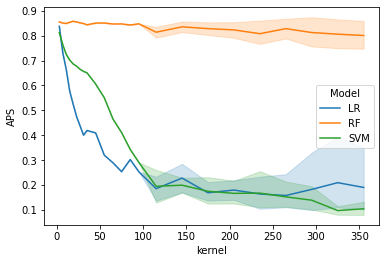

In [ ]:
sns.lineplot(data=metric_pdf,x='kernel',y='APS',hue='Model')

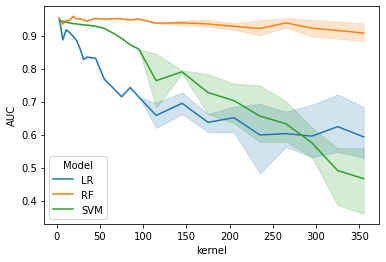

In [ ]:
sns.lineplot(data=metric_pdf,x='kernel',y='AUC',hue='Model')

#### Export the model according to the kernel-AUC metrics

In [17]:
best_kernel = 3
skip_x = 0
sample_size_x = TRAIN_SIZE

In [ ]:
# loop through each possible year
for idx,row in train_data.iterrows():

  # get the year and kernel_size information
  t0,t1,t2 = row['t0'],row['t1'],row['t2']
  k_size = row['k_size']
  
  # define the condition to avoide export all samples
  if (t0,t1) == proj_yr[limit_list][0:2] and k_size == best_kernel: 

    # get the best model and save it
    train_pattern = f"/content/G_drive/MyDrive/Data_Bank/training_patches_{t0}_and_{t1}_prj_{t2}_{best_kernel:02}_*.gz"
    X_train,y_train = get_dataset(train_pattern,k_size,FEATURES,skip_x,sample_size_x)

    # instantiate the models
    LR_model = LogisticRegression()
    RF_model = cuRFC(max_features=1.0,n_bins=8,n_estimators=30,max_depth=16)
    SVM_model = SVC(probability=True) 

    # train and save the best model
    for m,n in zip([LR_model,RF_model,SVM_model],['LR_model','RF_model','SVM_model']):

      # fit the models
      m.fit(X_train,y_train)
      m.fit(X_train,y_train)
      m.fit(X_train,y_train)

      # save the model  
      pickle.dump(m, open(f"/content/G_drive/MyDrive/Data_Bank/CA_models/{n}.pkl", "wb"))

      print(f'{n} was trained and saved to disk.')

[W] [04:46:35.805573] L-BFGS: max iterations reached
[W] [04:46:36.367469] L-BFGS: max iterations reached
[W] [04:46:36.935122] L-BFGS: max iterations reached
LR_model was trained and saved to disk.
RF_model was trained and saved to disk.
SVM_model was trained and saved to disk.


In [18]:
# load the models
best_RF = pickle.load(open(f"/content/G_drive/MyDrive/Data_Bank/CA_models/RF_model.pkl",'rb'))
best_LR = pickle.load(open(f"/content/G_drive/MyDrive/Data_Bank/CA_models/LR_model.pkl",'rb'))
best_SVM = pickle.load(open(f"/content/G_drive/MyDrive/Data_Bank/CA_models/SVM_model.pkl",'rb'))

### Step_3: Export the GEE-asset to Cloud-Storage as TF format, and make predictions

#### Export the gee-asset to geoTIFF

In [19]:
# a helper function to export tif to TF
def doExport(img,out_image_base,region,tile_dim = 2048):
  """Run the image export task.  Block until complete.
  """
  task = ee.batch.Export.image.toDrive(
      image = img.select(FEATURES_pred[:-1]).toFloat(),
      description = out_image_base,
      folder = EXPORT_FOLDER,
      fileNamePrefix = out_image_base,
      region = region.geometry().bounds(),
      scale = 30,
      maxPixels = 1e10,
      fileDimensions = tile_dim # the out tif will be 2048*2048 pixels
  )

  task.start()

In [ ]:
# # First, we need to export all img to drive

# for idx,row in train_data.iterrows():

#   # define the condition to avoide export all samples
#   if idx in [limit_list]:

#     # Define basic parameters
#     pred_image_base = f'CA_{row["t0"]}_and_{row["t1"]}_prj_{row["t2"]}'
#     pred_image = row['img_to_proj']

#     # Export
#     doExport(pred_image, pred_image_base, region)

#     # print out the process
#     print(f'Exporting {pred_image_base}')

#### Perform prediction/classification

In [49]:
# function to transform geo_tif into np.arr
def read_tif_as_arr(tif_path,pad_size):

  # read tif and get metadata
  img_tif = gdal.Open(tif_path)

  bd_n = img_tif.RasterCount
  gt = img_tif.GetGeoTransform()
  sr = img_tif.GetProjection()

  # read raster to array
  band_list = []
  for b in range(bd_n):
    band = img_tif.GetRasterBand(b+1).ReadAsArray()
    band_list.append(band)
    del band

  # convert the band_list into array, 
  # note the arr is structured as CHW
  arr = np.array(band_list)

  del img_tif
  del band_list

  # pad the array with edge values
  arr = np.pad(arr,((0,0),(pad_size,pad_size),(pad_size,pad_size)),'edge')

  return gt,sr,arr

In [41]:
# using numba to speed up this process
@jit(nopython=True)
def slice_arr_with_kernel(tif_arr, kenel_size,pad_size):

  # infer the CHW from tif_arr, note the true Height is H-2(pad_size); same to Width
  C = tif_arr.shape[0]
  H = tif_arr.shape[1] - pad_size*2
  W = tif_arr.shape[2] - pad_size*2

  # set an empty array to stroe the neighboor pixels
  emp_arr = np.empty( (H*W,kenel_size**2*C ))

  for i in range(1,H+1):
    for j in range(1,W+1):
      emp_arr[(i-1)*W+(j-1)] = np.ascontiguousarray(tif_arr[:,i-1:i+2,j-1:j+2]).reshape(-1)

  tif_arr = None

  return H, W ,emp_arr.astype(np.float32) 

In [39]:
# function to transform np_arr to geo_tif
def arry_to_geotif(in_arry,tif_name,gt,sr):

  # initiate raster driver
  driver = gdal.GetDriverByName('GTiff')
  driver.Register()

  # create empty raster with proj and geo_transformation
  outds = driver.Create(tif_name,xsize=in_arry.shape[1],ysize=in_arry.shape[0],
              bands=1,eType=gdal.GDT_Int16)
  outds.SetGeoTransform(gt)
  outds.SetProjection(sr)

  # writh array to rasterband
  outband = outds.GetRasterBand(1)
  outband.WriteArray(in_arry)
  outband.SetNoDataValue(-1)
  outband.FlushCache()

  # empty memory and finilize the arr_to_tif process
  del outds
  del outband  
  del in_arry 

Get the path to tif files

In [26]:
# define the img_tile size, this has to be the same as the tif been exported
tif_size = 2048

# get the dimensions of the image
img_dim = urban.getInfo()['bands'][0]['dimensions']
Y_length = img_dim[1]/tif_size
X_length = img_dim[0]/tif_size

# get the start coordinates of each img tile
y_len = math.ceil(Y_length)
x_len = math.ceil(X_length)

# put the starting coordinate into a list
tif_path = []

for y in range(y_len):
  for x in range(x_len):

    y_start = y * tif_size
    x_start = x * tif_size

    tif_path.append(f"/content/G_drive/MyDrive/Data_Bank/CA_1990_1992_and_1993_1995_prj_1996_1998-{y_start:010}-{x_start:010}.tif")


#### Make the prediction using best models

In [57]:
# loop through each tif to create long-vectors
pad_size = int((best_kernel - 1)/2)

for i,tif in enumerate(tif_path):

 
  #____________________________Transform tif_arr to long vector for later feeding the model_________________________

  # get the geo_transform,spatial_referece and tif array
  gt,sr,tif_arr = read_tif_as_arr(tif,pad_size)
  
  # get the Height/Width and the long vector from tif_arr after kernel-pixel-slicing  
  H, W, vector_arr = slice_arr_with_kernel(tif_arr, best_kernel, pad_size)
  del tif_arr 

  #_____________________________________Make prediction using the best model______________________________________

  for m,n in zip([best_RF,best_SVM,best_LR],['RF','SVM','LR']):
    # infer descriptions
    prj_info = tif.split('-')[0].split('/')[-1]
    desc = f"{prj_info}_{n}_{i:03}"

    # make prediction
    pred = (m.predict_proba(cp.array(vector_arr))[:,1]*10000).astype(np.int16).get()

    # save to tif
    arry_to_geotif(pred.reshape(H,W),f'/content/tf_tmp/{desc}.tif',gt,sr)

    # print out the process
    print(f"Finishi prediction of {desc}")
  
  # empty memory
  del pred 
  del vector_arr

  # Python garbage collector to releas memory immediately
  if i%22 == 0: 
    gc.collect()

  print(f'_______________________________{i+1}/{len(tif_path)}__________________________________')

Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_RF_485
Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_SVM_485
Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_LR_485
_______________________________486/552__________________________________
Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_RF_486
Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_SVM_486
Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_LR_486
_______________________________487/552__________________________________
Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_RF_487
Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_SVM_487
Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_LR_487
_______________________________488/552__________________________________
Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_RF_488
Finishi prediction of CA_1990_1992_and_1993_1995_prj_1996_1998_SVM_488
Finishi

### Step_4: Upload tif to GEE

In [ ]:
# upload from Colab to Gstore.
! gsutil -m cp /content/tf_tmp/*.tif gs://tf-gee/Urban_projection/CA_tif/

In [133]:
for ca_type in ['RF','SVM','LR']:
  
  # get the files of same type
  f = ! ls /content/tf_tmp/*{ca_type}*
  f = [i.split('tf_tmp/')[1] for i in f]

  # infer the asset name
  name = f[0][:-8]  

  # concat gs-path to tif-file
  f = [f"gs://tf-gee/Urban_projection/CA_tif/{i}" for i in f]
  f_long = " ".join(f)

  

  # create the upload cmd txt
  with open(f"{ca_type}.txt", "w") as text_file:
    text_file.write(f"earthengine upload image --asset_id=users/wangjinzhulala/GEE_TF/CA_prj_tif/{name} {f_long}")



In [134]:
# excute the cmd
! bash tmp.txt

bash: tmp.txt: No such file or directory
